In [2]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [4]:
def argspace(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [5]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [6]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [7]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [8]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [9]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [10]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

## save

In [11]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [12]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [13]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [14]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [15]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# dataset

In [16]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [17]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

## sampler

In [18]:
class ArchitectureSampler():
  def __call__(self, graph : nx.DiGraph, alpha : torch.Tensor) -> nx.DiGraph:
    return self.graph(graph, alpha)

In [19]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [20]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [21]:
class StrideCutSampler(ArchitectureSampler):
  def __init__(self, stride_max=8):
    assert stride_max >= 1
    self.stride = stride_max

  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if G.edges[i, j]['stride'] > self.stride]
      G.remove_edges_from(edges)

    return G

In [22]:
# model = load_model(dir="", gene='VGG19')
# g = model.graph
# sampler = StrideCutSampler(2)
# h = model.sampled_graph(sampler)
# render_graph(h, 'graph')
# # nx.graph_edit_distance(g, h)

## module

### component

In [23]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [24]:
class FactorizedReduce(nn.Module):
  def __init__(self, channel_in, channel_out, stride, affine=True):
    super(FactorizedReduce, self).__init__()
    assert channel_out % stride == 0
    
    self.convs = nn.ModuleList([
      nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
      for _ in range(stride)
    ])
    self.bn = nn.BatchNorm2d(channel_out, affine=affine)

  def forward(self, x):
    # strideの偶奇による情報ロスを防ぐ
    out = torch.cat([conv(x[:,:,i:,i:]) for i, conv in enumerate(self.convs)], dim=1)
    out = self.bn(out)
    return out

In [25]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if stride > 1:
      return FactorizedReduce(channel_in, channel_out, stride)
    elif channel_in != channel_out:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [26]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

### network

In [57]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None, preprocess : ArchitectureSampler=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = bool(graph)
    self.graph = graph if graph else self._make_graph(gene)
    self.graph = preprocess(self.graph, None) if preprocess else self.graph
    self.init_param = {'gene': gene, 'graph': graph, 'preprocess': preprocess}

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    def _mask(node_num, device, name):
      mask = torch.zeros(node_num, node_num, device=device)

      for i, j in self.graph.edges():
        op = self.graph.edges[i, j]['module']
        if not op == name: continue

        mask[i, j] = 1

      return mask.t() > 0

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    self.mask_s = _mask(n, device, 'shortcut')
    self.mask_f = _mask(n, device, 'forward')
    self.device = device

    self.alphas += [torch.ones(n, device=device, requires_grad=True)]

    return self

  def clone(self):
    model = Network(**self.init_param).to(self.device).init_alpha(self.device)
    for x, y in zip(model.alphas, self.alphas):
      x.data.copy_(y.data)
    return model

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      alpha[self.mask_f] = 1.0
      for a, raw, mask, b in zip(alpha, self.alphas[0], self.mask_s, self.normalized_beta()):
        a[mask] = b * F.softmax(raw[mask], dim=0)
    return alpha

  def normalized_beta(self):
    # f = lambda x : math.exp(x - 1) if x < 1 else math.log(x) + 1
    # return self.beta().apply_(f)
    x = self.beta()
    m = x>1
    beta = torch.zeros_like(x)
    beta[m] = torch.log(x[m]) + 1
    beta[~m] = torch.exp(x[~m] - 1)
    return beta

  def beta(self):
    return self.alphas[1]

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

## others

In [59]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device, optimizer, momentum, weight_decay):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.net_optimizer = optimizer
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device
    self.train = True

  def _loss(self, model, input, target):
    return self.criterion(model(input), target)

  def _concat(self, xs):
    return torch.cat([x.view(-1) for x in xs])

  def _compute_unrolled_model(self, input, target, eta):
    loss = self._loss(self.model, input, target)
    theta = self._concat(self.model.parameters()).data
    try:
      moment = self._concat(self.net_optimizer.state[v]['momentum_buffer'] for v in self.model.parameters()).mul_(self.momentum)
    except:
      moment = torch.zeros_like(theta)
    dtheta = self._concat(torch.autograd.grad(loss, self.model.parameters())).data + self.weight_decay*theta
    unrolled_model = self._construct_model_from_theta(theta.sub(eta, moment+dtheta))
    return unrolled_model

  def step(self, train, valid, eta, unrolled):
    # if not self.train: return

    input_train, target_train = train
    input_valid, target_valid = valid

    self.optimizer.zero_grad()
    if unrolled:
      self._backward_step_unrolled(input_train, target_train, input_valid, target_valid, eta)
    else:
      self._backward_step(input_valid, target_valid)
    self.optimizer.step()

  def _backward_step(self, input_valid, target_valid):
    loss = self._loss(self.model, input_valid, target_valid)
    loss.backward()

  def _backward_step_unrolled(self, input_train, target_train, input_valid, target_valid, eta):
    unrolled_model = self._compute_unrolled_model(input_train, target_train, eta)
    unrolled_loss = self._loss(unrolled_model, input_valid, target_valid)

    unrolled_loss.backward()
    dalpha = [v.grad for v in unrolled_model.alphas]
    vector = [v.grad.data for v in unrolled_model.parameters()]
    implicit_grads = self._hessian_vector_product(vector, input_train, target_train)

    for g, ig in zip(dalpha, implicit_grads):
      g.data.sub_(eta, ig.data)

    for v, g in zip(self.model.alphas, dalpha):
      if v.grad is None:
        v.grad = Variable(g.data)
      else:
        v.grad.data.copy_(g.data)

  def _construct_model_from_theta(self, theta):
    model_new = self.model.clone()
    model_dict = self.model.state_dict()

    params, offset = {}, 0
    for k, v in self.model.named_parameters():
      v_length = np.prod(v.size())
      params[k] = theta[offset: offset+v_length].view(v.size())
      offset += v_length

    assert offset == len(theta)
    model_dict.update(params)
    model_new.load_state_dict(model_dict)
    return model_new.to(self.device)

  def _hessian_vector_product(self, vector, input, target, r=1e-2):
    R = r / self._concat(vector).norm()
    for p, v in zip(self.model.parameters(), vector):
      p.data.add_(R, v)
    loss = self._loss(self.model, input, target)
    grads_p = torch.autograd.grad(loss, self.model.alphas)

    for p, v in zip(self.model.parameters(), vector):
      p.data.sub_(2*R, v)
    loss = self._loss(self.model, input, target)
    grads_n = torch.autograd.grad(loss, self.model.alphas)

    for p, v in zip(self.model.parameters(), vector):
      p.data.add_(R, v)

    return [(x-y).div_(2*R) for x, y in zip(grads_p, grads_n)]

In [30]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

In [31]:
def save_heatmap(data : torch.tensor, path, format='1.2f'):
  plt.figure()
  data = data.detach().cpu().clone().numpy()
  sns.heatmap(data, annot=True, fmt=format)
  plt.savefig(path)
  plt.close('all')

# learning

## events

In [32]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [33]:
@Experiment.event('setup')
def set_device(args):
  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

In [34]:
@Experiment.event('checkpoint', 'end', order=1)
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [35]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    input_search, target_search = next(iter(args.architect.valid_loader))
    input_search = Variable(input_search, requires_grad=False).to(args.device)
    target_search = Variable(target_search, requires_grad=False).to(args.device)

    args.architect.step((input, target), (input_search, target_search), args.lr, True)

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [36]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

## experiment

In [37]:
@argspace(gene='VGG11', stride_max=0, graph=None, dir=None)
def load_model(args):
  
  # init
  set_device(args)
  device = args.device

  # model setup
  gene = cfg[args.gene]
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  model = Network(gene, graph=args.graph, preprocess=sampler).to(device).init_alpha(device)

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']

  return model

In [41]:
@argspace(gene='VGG11', stride_max=0, save_weight=False)
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device

  # model setup
  gene = cfg[args.gene]
  logging.info('gene %s', gene)
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  graph = args.graph if args.graph else None
  model = Network(gene, graph=graph, preprocess=sampler).to(device).init_alpha(device)

  # load cuda
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  loader = load_dataloader(args)

  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device, optimizer, args.momentum, 5e-4)

  @Experiment.event('checkpoint', 'end')
  def save_model(args):
    state = {
      'model': model.state_dict(),
      'graph': model.graph,
      'alpha': model.alphas,
      'store': store,
      'epoch': epoch,
    }
    torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

  @Experiment.event('epoch_end')
  def save_graph(args):
    path = os.path.join(args.save, 'graph')
    if not os.path.exists(path):
      os.mkdir(path)
    sampler = MaxSampler()
    graph = model.sampled_graph(sampler)
    torch.save(graph, os.path.join(path, 'graph_%d.pth' % epoch))
    render_graph(graph, os.path.join(path, 'graph_%d' % epoch))

  @Experiment.event('epoch_end')
  def save_alpha(args):
    path = os.path.join(args.save, 'alpha')
    if not os.path.exists(path):
      os.mkdir(path)
    save_heatmap(model.matrix_alpha(), os.path.join(path, 'alpha_%d.png' % epoch))

  @Experiment.event('epoch_end')
  def save_weight(args):
    if not args.save_weight: return

    path = os.path.join(args.save, 'model')
    if not os.path.exists(path):
      os.mkdir(path)
    torch.save(model.state_dict(), os.path.join(path, 'model_%d.pth' % epoch))


  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    
    if not model.evaluate:
      logging.debug('raw %s', model.matrix_alpha(normalize=False))
      logging.debug('alpha %s', model.matrix_alpha())
      logging.debug('beta %s', model.beta())

    architect.train = epoch >= 10

    # training
    train_acc, train_obj = train(dataset=loader.train, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, lr=args.lr,
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    exp('epoch_end')(args)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)

  exp('end')(args)

  return model

# main

Experiment dir : exp_vgg19_beta-2020-10-06_15-45-08
10/06 06:45:08 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=50, gene='VGG19', graph=None, lr=0.01, lr_alpha=0.003, momentum=0.9, report=100, save='exp_vgg19_beta-2020-10-06_15-45-08', save_weight=True, seed=41, stride_max=2, test_size=5000, train_size=25000, valid_size=25000)
10/06 06:45:08 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
10/06 06:45:10 AM epoch 1
10/06 06:45:10 AM raw tensor([[ 1.3362e-03, -8.1917e-04,  1.5479e-04, -3.8901e-04, -5.3447e-04,
          5.5578e-04,  2.4798e-03,  6.0952e-04, -1.6285e-03, -2.9369e-04,
          6.1262e-04, -1.0814e-03,  1.2606e-04, -1.5184e-04,  1.9577e-03,
         -1.6091e-03, -2.4107e-04],
        [ 1.5794e-04,  1.7394e-04, -9.1592e-04,  8.6320e-04, -5.3613e-05,
         -6.6744e-04, -2.7883e-03,  9.9692e-04,  1.4753e-03,  9.5735

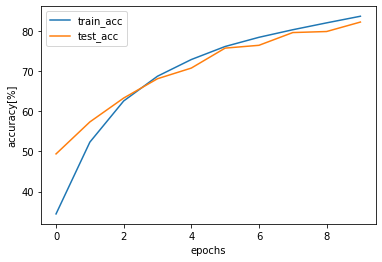

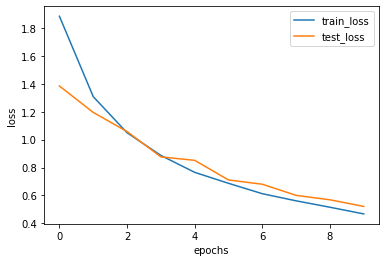

10/06 08:07:17 AM epoch 11
10/06 08:07:17 AM raw tensor([[ 5.2773e-42, -1.7012e-42, -1.8976e-15, -1.7096e-43, -3.9214e-34,
         -1.9380e-42,  1.7937e-42,  1.9058e-42,  1.4616e-42,  1.5624e-42,
         -1.4602e-42,  1.0159e-42, -1.9310e-42,  1.9856e-42, -1.0846e-42,
          1.8763e-42,  1.3298e-42],
        [ 1.0405e-41,  1.6605e-42,  1.9870e-42,  1.5232e-42, -2.5014e-01,
         -1.7446e-42,  1.7825e-42, -3.1529e-43,  8.7581e-43,  1.1953e-42,
         -1.3273e-11, -6.1657e-43, -2.0235e-42,  2.0571e-42, -1.9520e-42,
         -5.4931e-43, -2.9147e-43],
        [ 1.2163e-42,  6.9504e-43,  2.0893e-42,  1.1477e-42,  2.5022e-01,
          1.4534e-02, -4.8709e-01, -1.7373e-02,  2.8078e-02, -1.4251e-42,
          2.2012e-05, -3.8837e-18, -4.2179e-42, -1.3361e-38, -1.5706e-14,
          7.8333e-43, -6.6001e-43],
        [-9.1462e-38,  1.1151e-18,  1.9380e-42,  1.9240e-42,  1.8609e-42,
         -1.5334e-02, -3.4834e-01, -1.1803e-01, -7.6318e-02, -1.2878e-42,
         -1.8497e-42,  5.3950

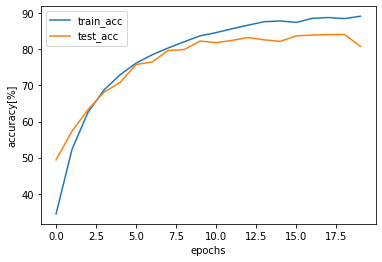

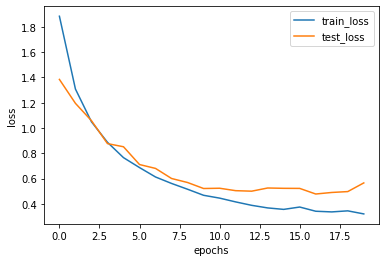

10/06 09:30:06 AM epoch 21
10/06 09:30:06 AM raw tensor([[-9.3747e-43, -1.7012e-42, -2.1005e-42, -1.7096e-43,  1.6437e-42,
         -1.9380e-42,  1.7937e-42,  1.9058e-42,  1.4616e-42,  1.5624e-42,
         -1.4602e-42,  1.0159e-42, -1.9310e-42,  1.9856e-42, -1.0846e-42,
          1.8763e-42,  1.3298e-42],
        [ 2.6227e-36,  1.6605e-42,  1.9870e-42,  1.5232e-42, -4.5906e-01,
         -1.7446e-42,  1.7825e-42, -3.1529e-43,  8.7581e-43,  1.1953e-42,
         -8.6866e-42, -6.1657e-43, -2.0235e-42,  2.0571e-42, -1.9520e-42,
         -5.4931e-43, -2.9147e-43],
        [ 1.2163e-42,  6.9504e-43,  2.0893e-42,  1.1477e-42,  4.5909e-01,
         -8.8064e-02, -4.2562e-01, -2.6955e-01, -8.7255e-03, -1.4251e-42,
          1.1925e-42, -1.6535e-43,  1.0041e-38,  1.6521e-42, -1.0159e-42,
          7.8333e-43, -6.6001e-43],
        [-8.0715e-43, -1.1771e-42,  1.9380e-42,  1.9240e-42,  1.8609e-42,
          8.7800e-02, -4.3565e-01, -1.9786e-01, -5.6345e-02, -1.2878e-42,
         -1.8497e-42,  5.3950

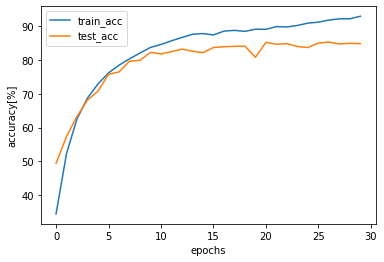

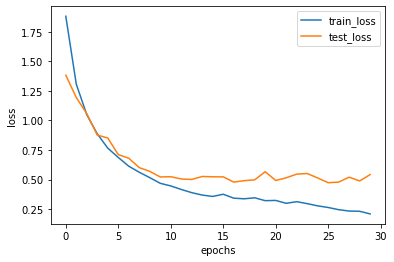

10/06 10:53:09 AM epoch 31
10/06 10:53:09 AM raw tensor([[-9.3747e-43, -1.7012e-42, -2.1005e-42, -1.7096e-43,  1.6437e-42,
         -1.9380e-42,  1.7937e-42,  1.9058e-42,  1.4616e-42,  1.5624e-42,
         -1.4602e-42,  1.0159e-42, -1.9310e-42,  1.9856e-42, -1.0846e-42,
          1.8763e-42,  1.3298e-42],
        [-1.0229e-42,  1.6605e-42,  1.9870e-42,  1.5232e-42, -6.3357e-01,
         -1.7446e-42,  1.7825e-42, -3.1529e-43,  8.7581e-43,  1.1953e-42,
         -4.0582e-42, -6.1657e-43, -2.0235e-42,  2.0571e-42, -1.9520e-42,
         -5.4931e-43, -2.9147e-43],
        [ 1.2163e-42,  6.9504e-43,  2.0893e-42,  1.1477e-42,  6.3359e-01,
         -2.6685e-01, -4.4936e-01, -2.3624e-01, -1.5131e-02, -1.4251e-42,
          1.1925e-42, -1.6535e-43,  1.9940e-42,  1.6521e-42, -1.0159e-42,
          7.8333e-43, -6.6001e-43],
        [-8.0715e-43, -1.1771e-42,  1.9380e-42,  1.9240e-42,  1.8609e-42,
          2.6674e-01, -1.8143e-01, -1.8182e-01, -6.0320e-02, -1.2878e-42,
         -1.8497e-42,  5.3950

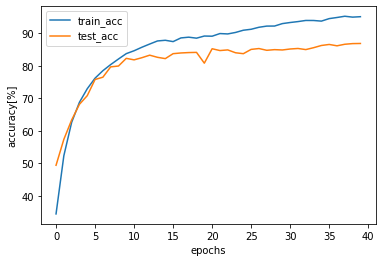

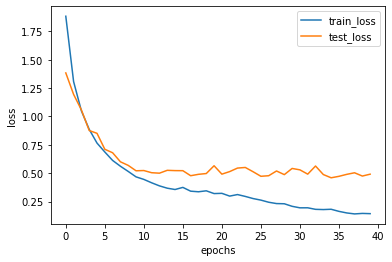

10/06 12:17:07 PM epoch 41
10/06 12:17:07 PM raw tensor([[-9.3747e-43, -1.7012e-42, -2.1005e-42, -1.7096e-43,  1.6437e-42,
         -1.9380e-42,  1.7937e-42,  1.9058e-42,  1.4616e-42,  1.5624e-42,
         -1.4602e-42,  1.0159e-42, -1.9310e-42,  1.9856e-42, -1.0846e-42,
          1.8763e-42,  1.3298e-42],
        [-1.0229e-42,  1.6605e-42,  1.9870e-42,  1.5232e-42, -7.2327e-01,
         -1.7446e-42,  1.7825e-42, -3.1529e-43,  8.7581e-43,  1.1953e-42,
         -1.9940e-42, -6.1657e-43, -2.0235e-42,  2.0571e-42, -1.9520e-42,
         -5.4931e-43, -2.9147e-43],
        [ 1.2163e-42,  6.9504e-43,  2.0893e-42,  1.1477e-42,  7.2328e-01,
         -2.7131e-01, -5.5267e-01, -3.1343e-01,  8.7386e-02, -1.4251e-42,
          1.1925e-42, -1.6535e-43,  1.9940e-42,  1.6521e-42, -1.0159e-42,
          7.8333e-43, -6.6001e-43],
        [-8.0715e-43, -1.1771e-42,  1.9380e-42,  1.9240e-42,  1.8609e-42,
          2.7126e-01, -1.0212e-02, -2.2437e-01, -2.5107e-01, -1.2878e-42,
         -1.8497e-42,  5.3950

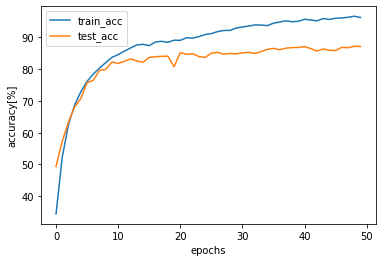

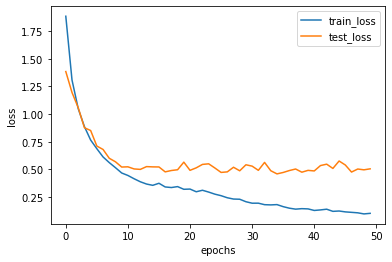

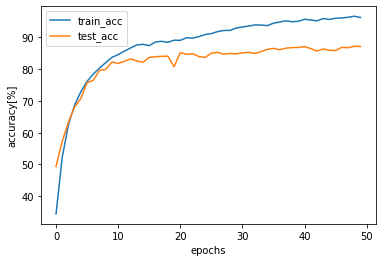

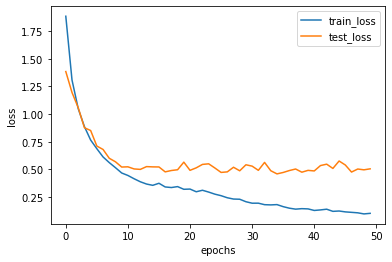

In [60]:
if __name__ == '__main__':
  main(save="exp_vgg19_beta", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=50, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       gene='VGG19', save_weight=True, stride_max=2,
       seed=41, report=100, checkpoint=10, dir="", graph=None)

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="drive/My Drive/ml/exp_vgg19_beta-2020-09-30_19-53-32", **args)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_vgg19_beta_eval", lr=0.005, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="drive/My Drive/ml/exp_vgg19_beta-2020-09-30_19-53-32", **args)
  
  sampler : ArchitectureSampler = ForwardSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_vgg19_beta_eval", lr=0.005, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)

In [ ]:
if __name__ == '__main__':
  model = load_model(dir="exp_beta_test-2020-09-30_14-22-10")
  
  sampler : ArchitectureSampler = ForwardSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_beta_test_base", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       gene='VGG11',
       seed=41, report=100, checkpoint=10, dir="", graph=graph)

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="exp_vgg19-2020-09-24_15-22-36", **args)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_vgg19_eval", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)
  

In [ ]:
if __name__ == '__main__':
  model = load_model(dir="exp-2020-09-24_08-53-44")
  
  # sampler : ArchitectureSampler = ForwardSampler()
  # graph = model.sampled_graph(sampler)
  # main(save="exp_eval_forward", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
  #     train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
  #     seed=41, report=100, checkpoint=10, dir="", graph=graph)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_eval_max", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
      train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
      seed=41, report=100, checkpoint=10, dir="", graph=graph)
  

# exp

TODO
- watch model size, memory
- early stopping